# Square-root EnKF with Lorenz 63 Model

## Imports

In [1]:
import numpy as np
import time
from numpy.linalg import inv
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import os
import lorenz63_model as lor

## Initialization of Variables

In [2]:
assim_len = 1.0
fcst_len  = 2.0
nassim    = 200
Nens = 10
inflate = 1.1

## Main Code

####   Code for running square-root EnKF with the Lorenz 63 model.
Developed by Aneesh Subramanian, Ryan Torn and Greg Hakim.

In [3]:
H = np.array([[1., 0., 0.], [0., 1., 0.], [0., 0., 1.]])  #  observation operator
#H = np.array([[1., 0., 0. ]]) #  observation operator for single observation
nobs = len(H[:,0])
R = np.eye(3) * 1.0e-2  #  observation error
#R = np.array([[1.0e-2]])  #  observation error for single observation

In [4]:
time1 = time.time()

np.random.seed(0)

fac = 1.0 / float(Nens-1)

In [5]:

# Initialize lists for storing errors
analysis_error_list = []
forecast_error_list = []


### IC for truth taken from last time (column vector):
# Calculate and store errors
analysis_error = np.linalg.norm(xaerr[t, :])
forecast_error = np.linalg.norm(xferr[t, :])

analysis_error_list.append(analysis_error)
forecast_error_list.append(forecast_error)


In [6]:
xt = np.array(lor.advance(10., 20., 30., 100.))

###  Create initial ensemble analysis and background arrays, add noise to analysis

In [7]:
xbens = np.empty((3,Nens))
xaens = np.empty((3,Nens))

for n in range(Nens):
  xaens[:,n] = xt[:]
xaens[:,:] = xaens[:,:] + np.random.normal(0,0.1,xaens.shape)

###  Create arrays related to ensemble mean, and K matrix

In [8]:
xam = np.empty(3)
xbm = np.empty(3)
xf  = np.empty(3)
xe  = np.empty(3)

###  Create error matricies

In [9]:
xaerr = np.empty((nassim, 3))
xberr = np.empty((nassim, 3))
xferr = np.empty((nassim, 3))

###  Create data assimilation matricies

In [14]:
innov   = np.empty(nobs)
yobs    = np.empty(nobs)
Hxa     = np.empty(Nens)
K       = np.empty(3)

for t in range(nassim):

  #  Advance the truth, compute observations
  xt[0], xt[1], xt[2] = lor.advance(xt[0], xt[1], xt[2], assim_len)
  yobs[:] = np.matmul(H,xt) + np.random.normal(0, np.diag(np.sqrt(R)), nobs)

  #  Advance each ensemble member to the next assimilation time, compute mean
  for n in range(Nens):
    xbens[0,n], xbens[1,n], xbens[2,n] = lor.advance(xaens[0,n], xaens[1,n], xaens[2,n], assim_len)

  xbm[:] = np.mean(xbens, axis=1)

  #  Prepare to assimilation observations, remove mean, inflate perturbations
  xaens[:,:] = xbens[:,:]
  xam[:] = xbm[:]

  for n in range(Nens):
    xaens[:,n] = (xaens[:,n] - xam[:]) * inflate

  for o in range(nobs):

    #  Evaluate each ensemble member's observation estimate
    for n in range(Nens):
      Hxa[n] = np.matmul(H[o,:],(xaens[:,n]+xam[:]))

    #  Compute ensemble mean observation estimate, innovation, remove mean
    hx = np.mean(Hxa)
    innov = yobs[o] - hx
    Hxa[:]= Hxa[:] - hx

    #  compute K, update the ensemble mean
    Kden   = fac * np.matmul(Hxa,np.transpose(Hxa)) + R[o,o]
    K      = (fac/Kden) * np.matmul(xaens,np.transpose(Hxa))
    xam[:] = xam[:] + K[:] * innov

    # update perturbations using modified gain
    beta= ( 1.0 + np.sqrt( R[o,o] / Kden ) )**-1

    for i in range(3):
      xaens[i,:] = xaens[i,:] - beta * K[i] * Hxa[:]

  print('analyzed values:', xam)
  print('verification   :', xt)

  #  Add mean back into the ensemble members
  for n in range(Nens):
    xaens[:,n] = xaens[:,n] + xam[:]

  xberr[t,:] = xbm[:] - xt[:]
  xaerr[t,:] = xam[:] - xt[:]

  # compute forecast and error
  xf[0], xf[1], xf[2] = lor.advance(xam[0], xam[1], xam[2], fcst_len)
  xe[0], xe[1], xe[2] = lor.advance(xt[0], xt[1], xt[2], fcst_len)

  xferr[t,:] = xf[:] - xe[:]
  # Calculate and store errors
  analysis_error = np.linalg.norm(xaerr[t, :])
  forecast_error = np.linalg.norm(xferr[t, :])

  analysis_error_list.append(analysis_error)
  forecast_error_list.append(forecast_error)


    
    
#   # Calculate the analysis error based on the provided formula
#   analysis_error = np.sqrt(sum(sum(xaerr[:] * xaerr[:])) / float(nassim * 3))
#   # Store the analysis error in a list if you want to track its evolution
#   analysis_error_list.append(analysis_error)


print('Analysis Error: ',np.sqrt(sum(sum(xaerr[:] * xaerr[:])) / float(nassim*3)))
print('Background Error: ',np.sqrt(sum(sum(xberr[:] * xberr[:])) / float(nassim*3)))
print('Forecast Error: ',np.sqrt(sum(sum(xferr * xferr)) / float(nassim*3)))

time2 = time.time()

print("Total Time:",time2-time1)

analyzed values: [-12.93398468 -11.26768917  34.52668857]
verification   : [-12.93133568 -11.29538258  34.4945599 ]
analyzed values: [-2.05756484 -1.72152194 20.21541425]
verification   : [-2.06057774 -1.72713755 20.21218687]
analyzed values: [ 0.11177309  0.21608994 10.04198999]
verification   : [ 0.11852954  0.22900832 10.03159429]
analyzed values: [ -7.68772669 -10.42347138  22.33123828]
verification   : [ -7.70610002 -10.48951671  22.22145112]
analyzed values: [-6.55012662 -4.02344789 28.05724845]
verification   : [-6.55221388 -3.94304389 28.15624553]
analyzed values: [ -9.7750611  -13.34439326  23.5229451 ]
verification   : [ -9.75771956 -13.33489429  23.47911817]
analyzed values: [-4.58234485 -2.53082586 25.6945196 ]
verification   : [-4.59574857 -2.57094648 25.66885073]
analyzed values: [ -8.71169757 -13.53333281  19.1911682 ]
verification   : [ -8.66643449 -13.48298148  19.1094737 ]
analyzed values: [-7.12893923 -0.0837137  33.03354156]
verification   : [-7.1611486  -0.10363396

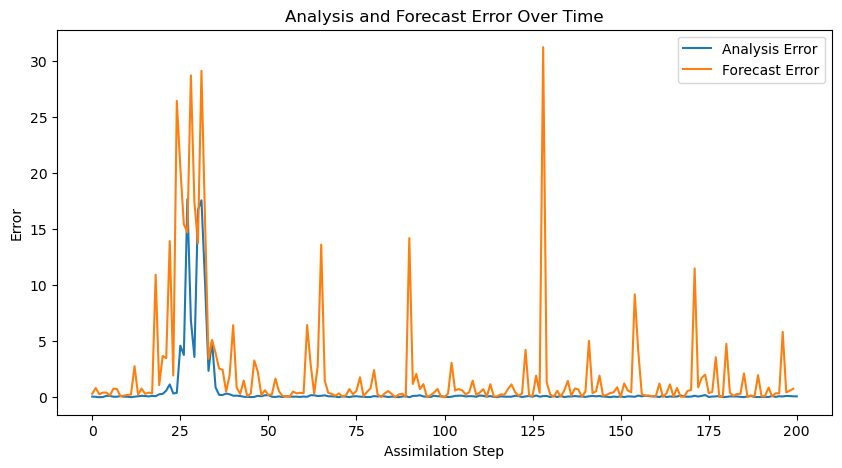

In [18]:

# Plot Errors
plt.figure(figsize=(10, 5))
plt.plot(analysis_error_list, label='Analysis Error')
plt.plot(forecast_error_list, label='Forecast Error')
plt.xlabel('Assimilation Step')
plt.ylabel('Error')
plt.title('Analysis and Forecast Error Over Time')
plt.legend()
plt.show()
